In [1]:
import pyro
import torch
from torch import nn
from pyro.infer import SVI, Trace_ELBO

# standard import
import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import seaborn as sns


In [2]:
"""
Torch/Pyro Implementation of (Unconditional) Normalizing Flow. In particular, as seen in RealNVP (z = x * exp(s) + t), where half of the 
dimensions in x are linearly scaled/transfromed as a function of the other half.
"""
import pyro
import torch
from torch import nn
from pyro.nn import DenseNN
import pyro.distributions as dist
from pyro.distributions.transforms import permute, BatchNorm
from pyro.distributions.transforms.affine_coupling import AffineCoupling
import itertools

class NormalizingFlow(nn.Module):
    """
    
    """
    def __init__(self, input_dim=2, split_dim=1, hidden_dim=128, num_layers=1, flow_length=10, 
                use_cuda=False):
        super(NormalizingFlow, self).__init__()
        self.base_dist = dist.Normal(torch.zeros(input_dim), torch.ones(input_dim)) # base distribution is Isotropic Gaussian
        self.param_dims = [input_dim-split_dim, input_dim-split_dim]
        # Define series of bijective transformations
        self.transforms = [AffineCoupling(split_dim, DenseNN(split_dim, [hidden_dim]*num_layers, self.param_dims)) for _ in range(flow_length)]
        self.perms = [permute(2, torch.tensor([1,0])) for _ in range(flow_length)]
        # Concatenate AffineCoupling layers with Permute Layers
        self.generative_flows = list(itertools.chain(*zip(self.transforms, self.perms)))[:-1] # generative direction (z-->x)
        self.normalizing_flows = self.generative_flows[::-1] # normalizing direction (x-->z)
        self.flow_dist = dist.TransformedDistribution(self.base_dist, self.generative_flows)
        
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()
            nn.ModuleList(self.transforms).cuda()
            self.base_dist = dist.Normal(torch.zeros(input_dim).cuda(),
                                         torch.ones(input_dim).cuda())
    
    def model(self, X=None):
        N = len(X) if X is not None else None
        pyro.module("nf", nn.ModuleList(self.transforms))
        with pyro.plate("data", N):
                obs = pyro.sample("obs", self.flow_dist, obs=X)
            
    def guide(self, X=None):
        pass
    
    def forward(self, z):
        zs = [z]
        for flow in self.generative_flows:
            z_i = flow(zs[-1])
            zs.append(z_i)
        return zs, z_i
    
    def backward(self, x):
        zs = [x]
        for flow in self.normalizing_flows:
            z_i = flow._inverse(zs[-1])
            zs.append(z_i)
        return zs, z_i
    
    def sample(self, num_samples):
        z_0_samples = self.base_dist.sample([num_samples])
        zs, x = self.forward(z_0_samples)
        return x
    
    def log_prob(self, x):
        return self.flow_dist.log_prob(x)
    
    def parameters(self):
        return nn.ModuleList([m for m in self.transforms if isinstance(m, nn.Module)]).parameters()


/Users/druhe/Projects/gw/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

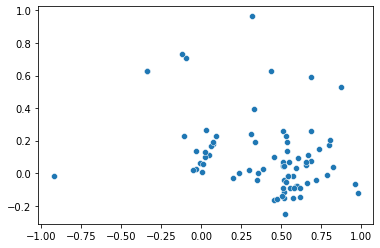

In [3]:
from data.m1q import M1QDataset

dataset = M1QDataset('../../datasets/Combined_GWTC_m1m2chieffz.npz', split='train')

(data,) = dataset[:]

data = data.mean(1)

sns.scatterplot(data[:, 0], data[:, 1])

ELBO: -30.77: 100%|█████████████████████████| 1024/1024 [00:19<00:00, 51.92it/s]


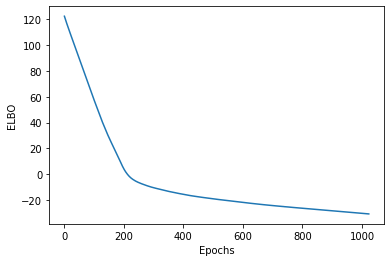

In [13]:
dataset = torch.utils.data.TensorDataset(data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000,
                        shuffle=True, num_workers=0)


flow = NormalizingFlow(input_dim=2, split_dim=1, hidden_dim=32, num_layers=1, flow_length=10, 
                    use_cuda=False)


optimizer = torch.optim.Adam(flow.parameters(), lr=0.0003)

svi = SVI(flow.model, flow.guide, pyro.optim.Adam({"lr": 0.0001}), Trace_ELBO(num_particles=1))



ELBO: -46.30: 100%|█████████████████████████| 1024/1024 [00:19<00:00, 52.63it/s]


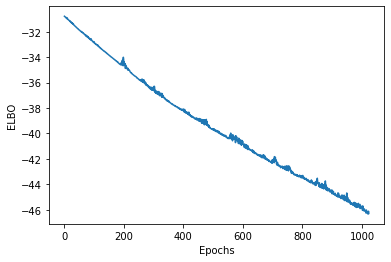

In [20]:

num_epochs = 1024
losses = []
pyro.clear_param_store()

epochs = tqdm.trange(num_epochs)
for epoch in epochs:
    try:
        running_loss = 0
        for (x_batch,) in dataloader:
            
            loss = svi.step(x_batch)
            running_loss += loss
        losses.append(running_loss)
        epochs.set_description("ELBO: {:.2f}".format(running_loss))
    except KeyboardInterrupt:
        plt.plot(losses);
        break
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("ELBO")
plt.show()

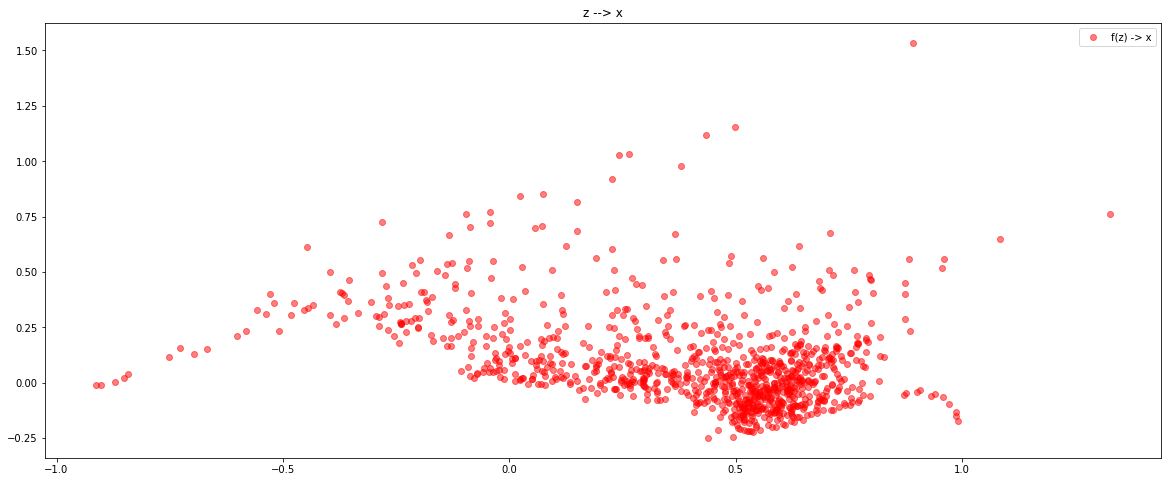

In [21]:
# Sample from trained NF
samples = flow.sample(num_samples=1000).detach()
fig = plt.figure(figsize=(20,8))
# plt.scatter(X_tensor[:, 0], X_tensor[:, 1], c="b", label="Data", alpha=0.8)
plt.scatter(samples[:, 0], samples[:, 1], c="r", alpha=0.5, label="f(z) -> x")
plt.title("z --> x")
plt.legend()

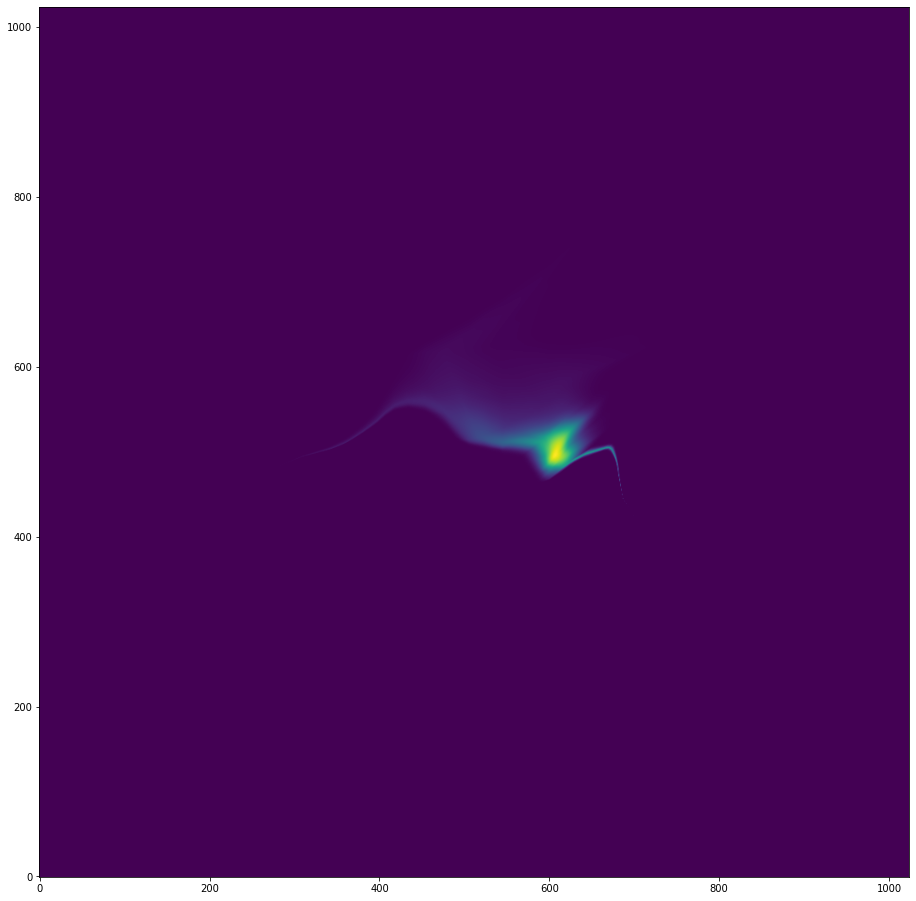

In [22]:
x = torch.linspace(-3, 3, 1024)
y = torch.linspace(-3, 3, 1024)

# x = torch.linspace(0, 4, 1024)


mesh = torch.stack(torch.meshgrid(y, x, indexing='xy')).view(2, -1).permute(1, 0)

p = flow.log_prob(mesh).exp()

p = p.view(1024, 1024)

plt.figure(figsize=(16, 16))
plt.imshow(p.detach().numpy(), origin='lower')

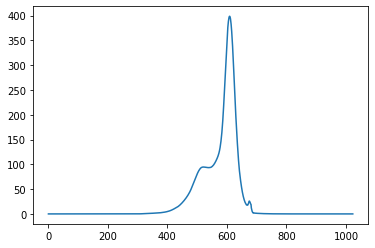

In [23]:
plt.plot(p.sum(0).detach())

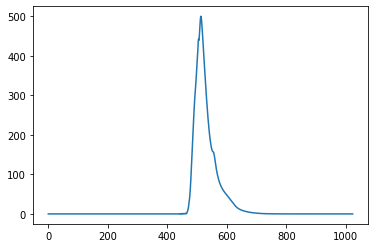

In [24]:
plt.plot(p.sum(1).detach())